In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('merged_preprocessed_crop_yield.csv')

print("Shape:", df.shape)
df.head()

Shape: (54804, 20)


,Year,Decade,State Name,State_encoded,Dist Name,Crop,Crop_encoded,Season,Season_encoded,Area_ha,N_req_kg_per_ha,P_req_kg_per_ha,K_req_kg_per_ha,Temperature_C,Humidity_%,pH,Rainfall_mm,Wind_Speed_m_s,Solar_Radiation_MJ_m2_day,Yield_kg_per_ha
0,1966,1960,chhattisgarh,3,durg,rice,3,Unknown,4,548000.0,8.43975,4.05108,7.42698,25,80,6.5,1200,2.0,18,337.59
1,1966,1960,chhattisgarh,3,durg,maize,2,Unknown,4,3000.0,18.00009,8.00004,11.33339,22,70,6.0,800,2.5,20,666.67
2,1966,1960,chhattisgarh,3,durg,chickpea,0,Unknown,4,54000.0,9.00000,5.00000,9.00000,20,60,6.5,600,1.5,16,500.00
3,1967,1960,chhattisgarh,3,durg,rice,3,Unknown,4,547000.0,18.69275,8.97252,16.44962,25,80,6.5,1200,2.0,18,747.71
4,1967,1960,chhattisgarh,3,durg,maize,2,Unknown,4,3000.0,27.00000,12.00000,17.00000,22,70,6.0,800,2.5,20,1000.00


In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [7]:
X = df.drop(columns=['Yield_kg_per_ha'])
y = df['Yield_kg_per_ha']

In [8]:
X = X.drop(columns=['State Name', 'Dist Name', 'Crop', 'Season'])

In [9]:
scaler = StandardScaler()

num_cols = X.select_dtypes(include=['int64','float64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

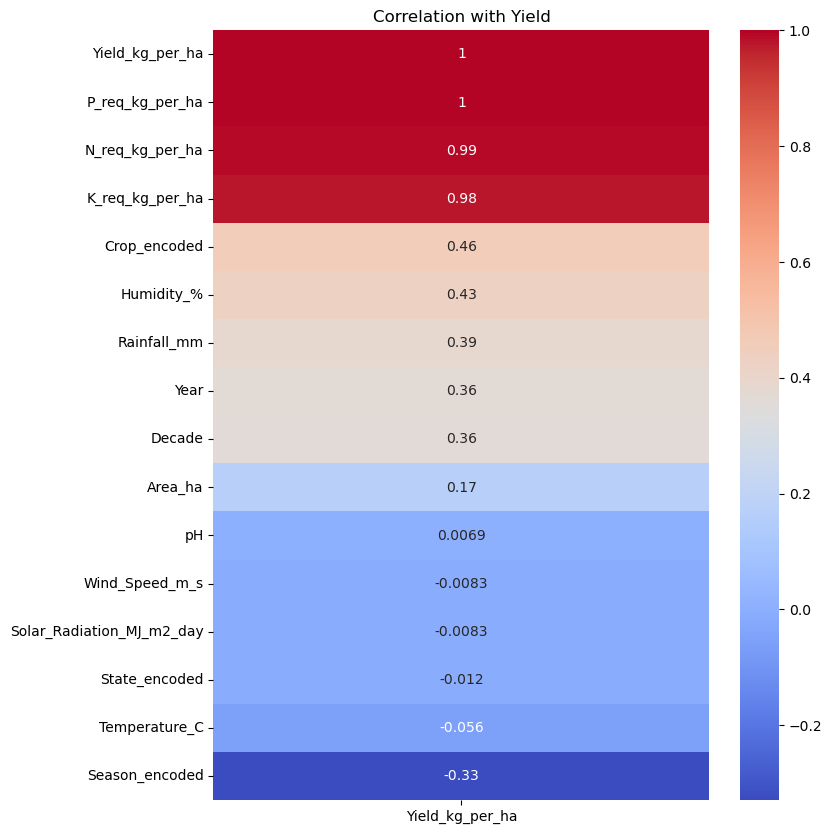

In [10]:
corr = pd.concat([X, y], axis=1).corr()

plt.figure(figsize=(8,10))
sns.heatmap(
    corr[['Yield_kg_per_ha']]
    .sort_values(by='Yield_kg_per_ha', ascending=False),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlation with Yield")
plt.show()

In [11]:
corr_threshold = 0.10
selected_features = corr['Yield_kg_per_ha'].abs()
selected_features = selected_features[selected_features > corr_threshold].index
selected_features = selected_features.drop('Yield_kg_per_ha')

X = X[selected_features]
X.shape

(54804, 10)

In [12]:
lr = LinearRegression()

rfe = RFE(lr, n_features_to_select=10)
rfe.fit(X, y)

rfe_features = X.columns[rfe.support_]
rfe_features

Index(['Year', 'Decade', 'Crop_encoded', 'Season_encoded', 'Area_ha',
       'N_req_kg_per_ha', 'P_req_kg_per_ha', 'K_req_kg_per_ha', 'Humidity_%',
       'Rainfall_mm'],
      dtype='object')

In [13]:
X = X[rfe_features]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((43843, 10), (10961, 10))

In [15]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_preds = lr_model.predict(X_test)

In [16]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [17]:
!pip install xgboost

   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.7 MB ? eta -:--:--
   ---------------------------------------- 0.5/101.7 MB 1.9 MB/s eta 0:00:53
   ---------------------------------------- 1.0/101.7 MB 2.4 MB/s eta 0:00:42
    --------------------------------------- 1.6/101.7 MB 2.4 MB/s eta 0:00:42
    --------------------------------------- 1.8/101.7 MB 2.2 MB/s eta 0:00:45
    --------------------------------------- 2.4/101.7 MB 2.2 MB/s eta 0:00:46
   - -------------------------------------- 2.9/101.7 MB 2.4 MB/s eta 0:00:42
   - -------------------------------------- 3.4/101.7 MB 2.4 MB/s eta 0:00:42
   - -------------------------------------- 3.9/101.7 MB 2.4 MB/s eta 0:00:42
   - -------------------------------------- 4.5/101.7 MB 2.3 MB/s eta 0:00:42
   - -------------------------------------- 4.7/101.7 MB 2.2 MB/s eta 0:00:44
   -- ------------------------------------- 5.5/101.7 MB 2.3 MB/s eta 0:00:42


In [18]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

In [19]:
def evaluate_model(name, y_true, y_pred):
    print(f"📊 {name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE :", mean_absolute_error(y_true, y_pred))
    print("R²  :", r2_score(y_true, y_pred))
    print("-"*40)

evaluate_model("Linear Regression", y_test, lr_preds)
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)

📊 Linear Regression
RMSE: 14.673815974357543
MAE : 9.336652483237946
R²  : 0.9997852275186131
----------------------------------------
📊 Random Forest
RMSE: 9.695531060050037
MAE : 0.3246934084482729
R²  : 0.9999062360915244
----------------------------------------
📊 XGBoost
RMSE: 44.646526049424466
MAE : 6.437169349015428
R²  : 0.9980117644151427
----------------------------------------


In [ ]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Random Forest", "XGBoost"],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, lr_preds)),
        np.sqrt(mean_squared_error(y_test, rf_preds)),
        np.sqrt(mean_squared_error(y_test, xgb_preds))
    ],
    "MAE": [
        mean_absolute_error(y_test, lr_preds),
        mean_absolute_error(y_test, rf_preds),
        mean_absolute_error(y_test, xgb_preds)
    ],
    "R² Score": [
        r2_score(y_test, lr_preds),
        r2_score(y_test, rf_preds),
        r2_score(y_test, xgb_preds)
    ]
})

results.style\
    .background_gradient(cmap="viridis", subset=["R² Score"])\
    .background_gradient(cmap="coolwarm_r", subset=["RMSE", "MAE"])\
    .format({"RMSE": "{:.2f}", "MAE": "{:.2f}", "R² Score": "{:.3f}"})

,Model,RMSE,MAE,R² Score
0,Linear Regression,14.67,9.34,1.000
1,Random Forest,9.70,0.32,1.000
2,XGBoost,44.65,6.44,0.998


In [24]:
!pip install shap

In [21]:
import shap

explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

 99%|===================| 10906/10961 [00:51<00:00]        

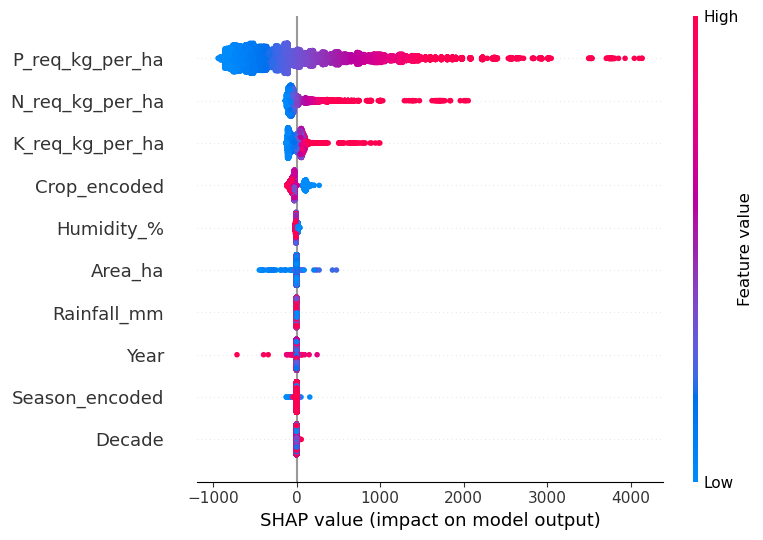

In [22]:
shap.summary_plot(shap_values, X_test)

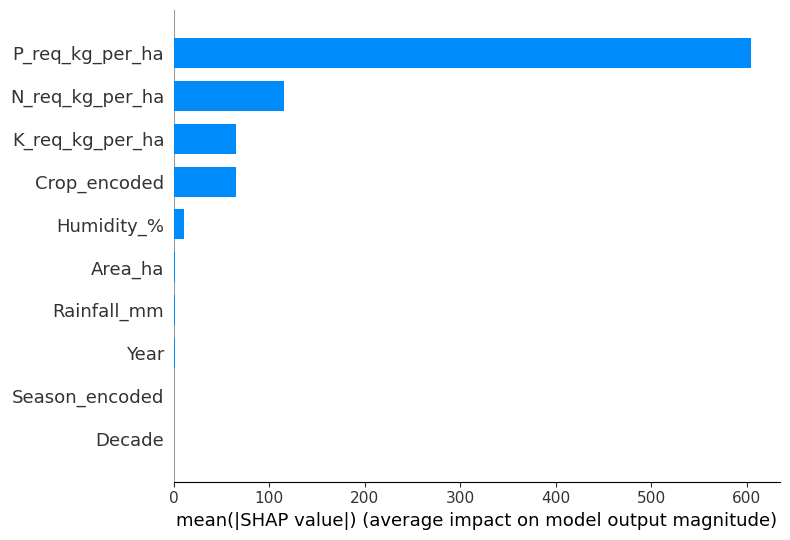

In [23]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

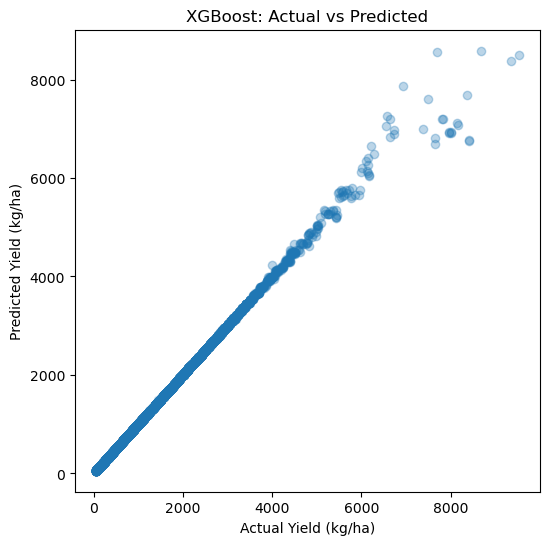

In [25]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, xgb_preds, alpha=0.3)
plt.xlabel("Actual Yield (kg/ha)")
plt.ylabel("Predicted Yield (kg/ha)")
plt.title("XGBoost: Actual vs Predicted")
plt.show()